In [1]:
import pandas as pd
from tqdm import tqdm
import re

In [2]:
f = open('./steam_over20.dat', 'r', encoding='ISO-8859-1')
movies = f.readlines()
movie_names = [_.split(' %% ')[1] for _ in movies]
movie_ids = [_.split(' %% ')[0] for _ in movies]
movie_dict = dict(zip(movie_ids, movie_names))
movie_categories_multi = [_.split(' %% ')[2].rstrip("\n").split('|') for _ in movies]
movie_categories = [[_[0]] for _ in movie_categories_multi]
movie_category_dict = dict(zip(movie_ids, movie_categories))
id_mapping = dict(zip(movie_ids, range(len(movie_ids))))

In [3]:
data = pd.read_csv("./ratings_over20.csv")
interaction_dicts = dict()
for index, row in tqdm(data.iterrows()):
    movie_id, user_id, rating, timestamp = str(row['item_id']), row['user_id'], row['rating'], row['timestamp']
    # if float(rating) <= 3.0: continue already positive
    if user_id not in interaction_dicts:
        interaction_dicts[user_id] = {
            'movie_id': [],
            'rating': [],
            'timestamp': [],
            'movie_title': [],
        }
    if movie_dict[movie_id] not in interaction_dicts[user_id]['movie_title']:
        interaction_dicts[user_id]['movie_id'].append(movie_id)
        interaction_dicts[user_id]['rating'].append(1)
        interaction_dicts[user_id]['timestamp'].append(timestamp)
        interaction_dicts[user_id]['movie_title'].append(movie_dict[movie_id])


1106982it [00:45, 24397.94it/s]


In [4]:
from collections import Counter

def acc_value(rating_list):
    return sum(rating_list)

def get_cate_list(id_list, movie_category_dict):
    cate_list = []
    for id_ in id_list:
        cate_list += movie_category_dict[id_]
    element_counts = Counter(cate_list)
    sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
    cate_list = [cate for cate, count in sorted_counts]
    return cate_list
    

In [5]:
from tqdm import tqdm
sequential_interaction_list = []
seq_len = 10
for user_id in tqdm(interaction_dicts):
    temp = zip(interaction_dicts[user_id]['movie_id'], interaction_dicts[user_id]['rating'], interaction_dicts[user_id]['timestamp'], interaction_dicts[user_id]['movie_title'])
    temp = sorted(temp, key=lambda x: int(x[2]))
    result = zip(*temp)
    interaction_dicts[user_id]['movie_id'], interaction_dicts[user_id]['rating'], interaction_dicts[user_id]['timestamp'], interaction_dicts[user_id]['movie_title'] = [list(_) for _ in result]
    
    if len(interaction_dicts[user_id]['movie_id'])-seq_len+1 <= seq_len: continue
    for i in range(seq_len, len(interaction_dicts[user_id]['movie_id'])-seq_len+1):
        sequential_interaction_list.append(
            {"uid": user_id, 
             "history_title": interaction_dicts[user_id]['movie_title'][i - seq_len: i],
             "history_id": interaction_dicts[user_id]['movie_id'][i-seq_len:i], 
             "history_rating": interaction_dicts[user_id]['rating'][i-seq_len:i], 
             "future_title": interaction_dicts[user_id]['movie_title'][i : i + seq_len], 
             "future_id": interaction_dicts[user_id]['movie_id'][i : i + seq_len], 
             "future_rating": interaction_dicts[user_id]['rating'][i : i + seq_len], 
             "acc_label": acc_value(interaction_dicts[user_id]['rating'][i-seq_len:i]),
             "history_cates": get_cate_list(interaction_dicts[user_id]['movie_id'][i - seq_len: i], movie_category_dict), 
             "future_cates": get_cate_list(interaction_dicts[user_id]['movie_id'][i : i + seq_len], movie_category_dict), 
             "time": interaction_dicts[user_id]['timestamp'][i]}
        )
print(len(sequential_interaction_list))

  0%|          | 0/25944 [00:00<?, ?it/s]

100%|██████████| 25944/25944 [00:09<00:00, 2624.24it/s]

444319


In [6]:
sequential_interaction_list[0] 

{'uid': '₮ʜᴇ Wᴀʀᴛᴏɴ',
 'history_title': ['Papers, Please',
  'Day of Defeat: Source',
  'Youtubers Life',
  'Life is Strange - Episode 1',
  'Clicker Heroes',
  'Saints Row: The Third',
  'Grand Theft Auto: San Andreas',
  'Far CryÂ® 4',
  'Saints Row 2',
  'Saints Row IV'],
 'history_id': ['239030',
  '300',
  '428690',
  '319630',
  '363970',
  '55230',
  '12120',
  '298110',
  '9480',
  '206420'],
 'history_rating': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'future_title': ['Saints Row: Gat out of Hell',
  'Fallout Shelter',
  'Borderlands 2',
  'How to Survive 2',
  'Fahrenheit: Indigo Prophecy Remastered',
  'The Walking Dead: Michonne - A Telltale Miniseries',
  'Tap Heroes',
  'The Walking Dead',
  'Grand Theft Auto: Episodes from Liberty City',
  'Poker Night at the Inventory'],
 'future_id': ['301910',
  '588430',
  '49520',
  '360170',
  '312840',
  '429570',
  '371570',
  '207610',
  '12220',
  '31280'],
 'future_rating': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'acc_label': 10,
 'history_ca

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


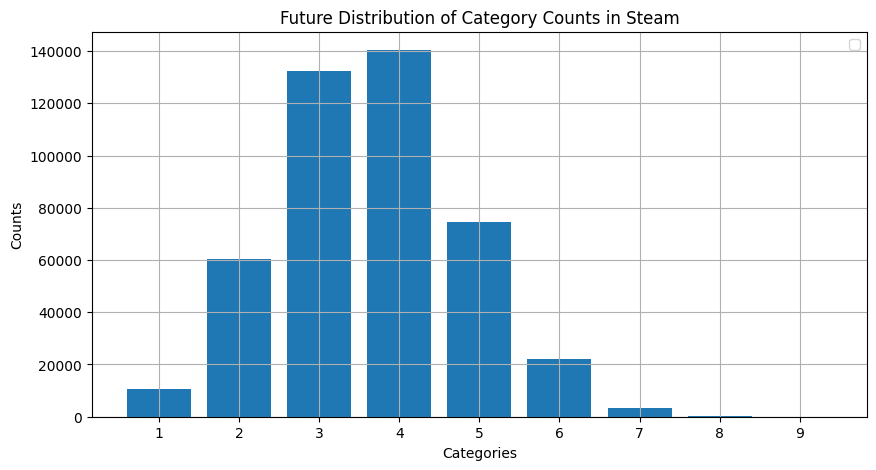

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


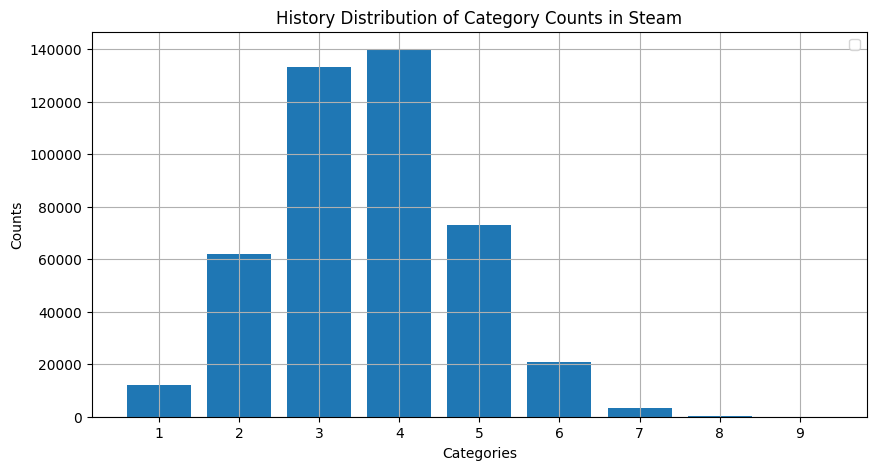

In [7]:
import matplotlib.pyplot as plt

future_cate_len_list = [len(_['future_cates']) for _ in sequential_interaction_list]
history_cate_len_list = [len(_['history_cates']) for _ in sequential_interaction_list]

def plot_count_cate(cate_len_list, name=''):
    element_counts = Counter(cate_len_list)

    sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
    
    elements, counts = zip(*sorted_counts)

    plt.figure(figsize=(10, 5))
    bars = plt.bar(elements, counts, tick_label=elements)
    
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title(f'{name} Distribution of Category Counts in Steam')
    plt.grid(True)
    
    plt.xticks(elements)
    
    plt.legend()

    plt.show()
    
plot_count_cate(future_cate_len_list, 'Future')
plot_count_cate(history_cate_len_list, 'History')

In [8]:
sorted_list = sorted(sequential_interaction_list, key=lambda x: int(x["time"]))
saved_list = [[_["uid"], _["history_title"], _["history_id"], _["future_title"], _["future_id"], _["acc_label"], _["history_cates"], _["future_cates"], _["time"]] for _ in sorted_list]
import csv
with open('./train.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'history_title', 'history_id', 'future_title', 'future_id',  'acc_value', 'history_cates', 'future_cates', 'timestamp'])
    writer.writerows(saved_list[:int(len(saved_list)*0.8)])
with open('./valid.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'history_title', 'history_id', 'future_title', 'future_id',  'acc_value', 'history_cates', 'future_cates',  'timestamp'])
    writer.writerows(saved_list[int(len(saved_list)*0.8):int(len(saved_list)*0.9)])
with open('./test.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'history_title', 'history_id', 'future_title', 'future_id',  'acc_value', 'history_cates', 'future_cates',  'timestamp'])
    writer.writerows(saved_list[int(len(saved_list)*0.9):])

In [9]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BIGRec(input_path, output_path, sample=False, sample_num=5000):
    # for BIGRec baseline
    data = pd.read_csv(input_path)
    if sample:
        data = data.sample(n=sample_num, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
    json_list = []
    for index, row in tqdm(data.iterrows()):
        row['history_title'] = eval(row['history_title'])
        L = len(row['history_title'])
        history = "The user has played the following games before:"
        for i in range(L):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\""
            else:
                history += ", \"" + row['history_title'][i] + "\""
                
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        json_list.append({
            "instruction": "Given a list of video games in Steam the user likes, please recommend 10 new games that the user likes to the user and end each game with the sign \"|\".",
            "input": f"{history}\n ",
            "output": future,
        })        
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)
# csv_to_json_BIGRec('./train.csv', './train_BIGRec_1000.json', sample=True, sample_num=1000)
# csv_to_json_BIGRec('./valid.csv', './valid_BIGRec_1000.json', sample=True, sample_num=1000)
# csv_to_json_BIGRec('./test.csv', './test_BIGRec_1000.json', sample=True, sample_num=1000)

In [10]:
def csv_to_json_RAW(input_path, output_path, sample=False, sample_num=5000):
    # for raw inference, constrain the LLM's output
    data = pd.read_csv(input_path)
    if sample:
        data = data.sample(n=sample_num, random_state=42).reset_index(drop=True)
        #data.to_csv(output_path[:-5] + ".csv", index=False)
    json_list = []
    for index, row in tqdm(data.iterrows()):
        row['history_title'] = eval(row['history_title'])
        L = len(row['history_title'])
        history = "The user has played the following games before:"
        for i in range(L):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\""
            else:
                history += ", \"" + row['history_title'][i] + "\""
                
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        json_list.append({
            "instruction": "Given a list of video games in Steam the user likes, please recommend 10 new games that the user likes to the user. End each game with the sign \"|\" and output the names only, without explanations or numbers. The output format should be like \'\"Game1\"| \"Game2\"| ...| \"Game10\"| \'.",
            "input": f"{history}\n ",
            "output": future,
        })        
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)
# csv_to_json_RAW('./test.csv', './test_RAW_1000.json', sample=True, sample_num=1000)

In [11]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BERT(input_path, output_path_GL, output_path_GP, output_path_GP_genre, output_path_GF, output_path_IP, sample=False, n=5000):
    # the data for DLCRec
    # what we really use is the dataset for GF and IP
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        # data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_dict = {
        'GL': [],
        'GP': [],
        'GF': [],
        'GP_genre': [],
        'IP': []
    }
    
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        history_cate = [movie_category_dict[hi][0] for hi in history_id]
        
        history_tuples = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, history_cate)]
        
        history_tuples_GL_input = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, '?' * len(history_cate))]
        history_tuples_GL_output = history_tuples

        history = ', '.join(history_tuples)

        future_title = eval(row['future_title'])
        future_id = eval(row['future_id'])
        future_cate = [movie_category_dict[fi][0] for fi in future_id]
        
        future_tuples_GL = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title), '_' * len(future_cate))]
                
        future_tuples_GP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title), '?' * len(future_cate))]
        future_tuples_GP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title), future_cate)]
            
        future_tuples_IP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('?' * len(future_title), future_cate)]
        future_tuples_IP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip(future_title, future_cate)]

        
        trail_GL_input = ', '.join(history_tuples_GL_input + future_tuples_GL)
        trail_GL_output = ', '.join(history_tuples_GL_output + future_tuples_GL)
        
        trail_GP_input = ', '.join(history_tuples + future_tuples_GP_input)
        trail_GP_output = ', '.join(history_tuples + future_tuples_GP_output)
        
        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        GF_genres = '[' + '| '.join(eval(row['future_cates'])) + ']' # set of future_cate
        
        json_dict['GL'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\". The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GL_input}",
            "output": trail_GL_output,
        })
        json_dict['GP'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\". The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GP_input}",
            "output": trail_GP_output,
        })
        json_dict['GP_genre'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\" with exactly {len(set(future_cate))} types. The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GP_input}",
            "output": trail_GP_output,
        })
        json_dict['GF'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\" with the following genres: {GF_genres}. The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GP_input}",
            "output": trail_GP_output,
        })
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the game placeholders represented by \"?\". The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })
 
    # with open(output_path_GL, 'w') as f:
    #     json.dump(json_dict['GL'], f, indent=4)
        
    # with open(output_path_GP, 'w') as f:
    #     json.dump(json_dict['GP'], f, indent=4)
    
    # with open(output_path_GP_genre, 'w') as f:
    #     json.dump(json_dict['GP_genre'], f, indent=4)
    
    with open(output_path_GF, 'w') as f:
        json.dump(json_dict['GF'], f, indent=4)
        
    with open(output_path_IP, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)


In [12]:
csv_to_json_BERT('./train.csv', './train_1000_BERT_GL.json', './train_1000_BERT_GP.json', './train_1000_BERT_GP_genre.json', './train_1000_BERT_GF.json', './train_1000_BERT_IP.json', sample=True, n=1000)
csv_to_json_BERT('./valid.csv', './valid_1000_BERT_GL.json', './valid_1000_BERT_GP.json', './valid_1000_BERT_GP_genre.json', './valid_1000_BERT_GF.json', './valid_1000_BERT_IP.json', sample=True, n=1000)
csv_to_json_BERT('./test.csv', './test_1000_BERT_GL.json', './test_1000_BERT_GP.json', './test_1000_BERT_GP_genre.json', './test_1000_BERT_GF.json', './test_1000_BERT_IP.json', sample=True, n=1000)
# csv_to_json_BERT('./train.csv', './train_5000_BERT_GL.json', './train_5000_BERT_GP.json', './train_5000_BERT_GP_genre.json', './train_5000_BERT_GF.json', './train_5000_BERT_IP.json', sample=True, n=5000)
# csv_to_json_BERT('./valid.csv', './valid_5000_BERT_GL.json', './valid_5000_BERT_GP.json', './valid_5000_BERT_GP_genre.json', './valid_5000_BERT_GF.json', './valid_5000_BERT_IP.json', sample=True, n=5000)
# csv_to_json_BERT('./test.csv', './test_5000_BERT_GL.json', './test_5000_BERT_GP.json', './test_5000_BERT_GP_genre.json', './test_5000_BERT_GF.json', './test_5000_BERT_IP.json', sample=True, n=5000)



1000it [00:00, 5345.61it/s]
1000it [00:00, 5472.09it/s]
1000it [00:00, 5449.00it/s]


In [13]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BERT_IP_pureitem(input_path, output_path_IP, sample=False, n=5000):
    # you can use it to get the dataset with the sameformat as task IP but with no genres
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        # data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_dict = {
        'IP': []
    }
    
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        
        history_tuples = ['\"' + ht + '\"' for ht in (history_title)]

        history = ', '.join(history_tuples)

        future_title = eval(row['future_title'])
        future_id = eval(row['future_id'])
        
        future_tuples_IP_input = ['\"' + ft + '\"'  for ft in '?' * len(future_title)]
        future_tuples_IP_output = ['\"' + ft + '\"' for ft in future_title]

        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        GF_genres = '[' + ', '.join(eval(row['future_cates'])) + ']' # set of future_cate
        
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\". Your task is to fill in the game placeholders represented by \"?\". The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })
        
    with open(output_path_IP, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)
# csv_to_json_BERT_IP_pureitem('./train.csv', './train_1000_BERT_IP_pi.json', sample=True, n=1000)
# csv_to_json_BERT_IP_pureitem('./valid.csv', './valid_1000_BERT_IP_pi.json', sample=True, n=1000)
# csv_to_json_BERT_IP_pureitem('./test.csv',  './test_1000_BERT_IP_pi.json', sample=True, n=1000)


In [14]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_GP(input_path, output_path, sample=False, n=5000, is_num=True):
    # for datasets of task GP
    # is_num = True means we include the control number in the prompt
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has played the following games with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        row['future_cates'] = eval(row['future_cates'])
        future = ""
        for i in range(len(row['future_cates'])):
            if i == 0:
                future += row['future_cates'][i]
            else:
                future += "| " + row['future_cates'][i]
        if is_num:
            json_list.append({
                "instruction": f"Given a list of video games in Steam and their corresponding genres the user has read before, please provide the {len(row['future_cates'])} most likely genres in the future recommendation list. Output the genres only, without game names, explanations or numbers. The output format is \"Genre1| Genre2| ...| Genre{len(row['future_cates'])}\".",
                "input": f"{history}.\n",
                "output": future,
            })    
        else:
            json_list.append({
                "instruction": f"Given a list of video games in Steam and their corresponding genres the user has read before, please provide the most likely genres in the future recommendation list of 10 games. Output the genres only, without game names, explanations or numbers. The output format is \"Genre1| Genre2| ...\".",
                "input": f"{history}.\n",
                "output": future,
            })
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)


In [15]:
csv_to_json_GP('./train.csv', './train_1000_GP.json', sample=True, n=1000)
csv_to_json_GP('./valid.csv', './valid_1000_GP.json', sample=True, n=1000)
csv_to_json_GP('./test.csv', './test_1000_GP.json', sample=True, n=1000)
# csv_to_json_GP('./train.csv', './train_1000_GPnonum.json', sample=True, n=1000, is_num=False)
# csv_to_json_GP('./valid.csv', './valid_1000_GPnonum.json', sample=True, n=1000, is_num=False)
# csv_to_json_GP('./test.csv', './test_1000_GPnonum.json', sample=True, n=1000, is_num=False)


In [16]:
def csv_to_json_noCoT(input_path, output_path, sample=False, n=5000, genre_control=0):
    # baseline BIGRec_div, simply add the control number in the prompt
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        #data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has read the following games with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
                        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        json_sample = {
            "instruction": f"Given a list of video games in Steam and their corresponding genres the user has read before, please recommend 10 new games that the user likes to the user with {genre_num} genres. The genres of the suggested movies should correspond precisely to the genres you have made up. End each game with the sign \"|\" and output the game only, without genres, explanations or numbers. \
The output format should be like \"Game1| Game2| ... Game10| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)
# csv_to_json_noCoT('./train.csv', './train_noCoT_1000.json', sample=True, n=1000)
# csv_to_json_noCoT('./valid.csv', './valid_noCoT_1000.json', sample=True, n=1000)
# csv_to_json_noCoT('./test.csv', './test_noCoT_1000.json', sample=True, n=1000)
# csv_to_json_noCoT('./test.csv', './test_noCoT_1000_2.json', sample=True, n=1000, genre_control=2)
# csv_to_json_noCoT('./test.csv', './test_noCoT_1000_5.json', sample=True, n=1000, genre_control=5)
# csv_to_json_noCoT('./test.csv', './test_noCoT_1000_8.json', sample=True, n=1000, genre_control=8)

In [17]:
def csv_to_json_CoT(input_path, output_path, sample=False, n=5000, genre_control=0):
    # baseline BIGRec_CoT, use chain-of-thought
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has read the following games with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
                        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        json_sample = {
            "instruction": f"Given a list of video games in Steam and their corresponding genres the user has read before, please think of the {genre_num} most likely genres in the future recommendation list. \
According to the history and future genres, please recommend 10 new games that the user likes to the user. The genres of the suggested movies should correspond precisely to the genres you have made up. End each game with the sign \"|\" and output the game only, without genres, explanations or numbers. \
The output format should be like \"Game1| Game2| ... Game10| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)
# csv_to_json_CoT('./train.csv', './trainCoT_1000.json', sample=True, n=1000)
# csv_to_json_CoT('./valid.csv', './validCoT_1000.json', sample=True, n=1000)
# csv_to_json_CoT('./test.csv', './testCoT_1000.json', sample=True, n=1000)
# csv_to_json_CoT('./test.csv', './testCoT_1000_2.json', sample=True, n=1000, genre_control=2)
# csv_to_json_CoT('./test.csv', './testCoT_1000_5.json', sample=True, n=1000, genre_control=5)
# csv_to_json_CoT('./test.csv', './testCoT_1000_8.json', sample=True, n=1000, genre_control=8)

data augmentation

In [18]:
train_data_1000 = pd.read_csv('./train_1000_GP.csv')
train_data_1000_his_ids = list(train_data_1000['history_id'].map(eval))
train_data_1000_his_genres  = [[movie_category_dict[id][0] for id in ids] for ids in train_data_1000_his_ids]
train_data_1000_fut_ids = list(train_data_1000['future_id'].map(eval))
train_data_1000_fut_genres = [[movie_category_dict[id][0] for id in ids] for ids in train_data_1000_fut_ids]

In [19]:
train_data_1000_his_genres_list = []
for his_genres in train_data_1000_his_genres:
    train_data_1000_his_genres_list += his_genres
    
his_genre_counts = Counter(train_data_1000_his_genres_list)
sorted_counts = sorted(his_genre_counts.items(), key=lambda x: x[1], reverse=True)

total_count = sum(count for _, count in sorted_counts)
probabilities_genres = [(genre, count / total_count) for genre, count in sorted_counts]

In [20]:
probabilities_genres
# [('Action', 0.6048),
#  ('Adventure', 0.1269),
#  ('Indie', 0.0888),
#  ('Strategy', 0.0455),
#  ('RPG', 0.0446),
#  ('Casual', 0.0419),
#  ('Simulation', 0.0183),
#  ('Free to Play', 0.0128),
#  ('Racing', 0.0087),
#  ('Sports', 0.0026),
#  ('Massively Multiplayer', 0.002),
#  ('Animation & Modeling', 0.0014),
#  ('Utilities', 0.0011),
#  ('Design & Illustration', 0.0003),
#  ('Audio Production', 0.0002),
#  ('Video Production', 0.0001)]

[('Action', 0.6129),
 ('Adventure', 0.1277),
 ('Indie', 0.0848),
 ('RPG', 0.0434),
 ('Casual', 0.0419),
 ('Strategy', 0.0391),
 ('Simulation', 0.0189),
 ('Free to Play', 0.0144),
 ('Racing', 0.0105),
 ('Massively Multiplayer', 0.0015),
 ('Sports', 0.0015),
 ('Animation & Modeling', 0.0014),
 ('Utilities', 0.0013),
 ('Design & Illustration', 0.0003),
 ('Audio Production', 0.0003),
 ('Education', 0.0001)]

In [21]:
train_data_1000_his_ids_list = []
for his_ids in train_data_1000_his_ids:
    train_data_1000_his_ids_list += his_ids
    
his_id_counts = Counter(train_data_1000_his_ids_list)
sorted_counts = sorted(his_id_counts.items(), key=lambda x: x[1], reverse=True)

total_count = sum(count for _, count in sorted_counts)
probabilities_ids = [(id, count / total_count) for id, count in sorted_counts]

prob_item_per_genre = {}
for id_, prob in probabilities_ids:
    genre = movie_category_dict[id_][0]
    if genre not in prob_item_per_genre:
        prob_item_per_genre[genre] = {}
    prob_item_per_genre[genre][id_] = prob
# probabilities_ids
# [('440', 0.0066),
#  ('221100', 0.0059),
#  ('620', 0.0054),
#  ('49520', 0.0054),
#  ('377160', 0.005),
#  ('220', 0.005),
#  ('252490', 0.0046),

In [22]:
def GFN_augment(input_path, dump_path, probabilities):
    random.seed(0)
    with open(input_path, 'r') as f:
        data = json.load(f)
        for i, sample in enumerate(data):
            # instruction extract sub; output sub 
            target_genres_pattern = re.compile(r'\[(.*?)\]')
            match = target_genres_pattern.findall(sample['instruction'])
            if match != None: target_genres_ori = match[0].split('| ')
            else: print(f'{i}th sample errors!')
            
            #print(target_genres_ori)
            chosen_genre = random.choice(target_genres_ori)
            #print(f"Chosen genre from the existing list: {chosen_genre}")
            other_genres, other_probabilities = [], []
            for genre in probabilities:
                if genre not in target_genres_ori:
                    other_genres.append(genre)
                    other_probabilities.append(probabilities[genre])
            #print(other_genres, sum(other_probabilities))
            selected_genre = random.choices(other_genres, weights=other_probabilities, cum_weights=None)[0]
            sample['instruction'] = re.sub(chosen_genre, selected_genre, sample['instruction'])
            #print(selected_genre)
            sample['output'] = re.sub("\"_\"'" + chosen_genre, "\"_\"'" + selected_genre, sample['output'])
    with open(dump_path, 'w') as f:
        json.dump(data, f, indent=4)
    
GFN_augment('./train_1000_BERT_GF.json', './train_1000_BERT_GF_n', dict(probabilities_genres))

In [23]:
def GFD_IPD_augment(input_path, GF_dump_path, IP_dump_path, probabilities, prob_item_per_genre):
    random.seed(0)
    data = pd.read_csv(input_path)
    json_dict = {
        'GF': [],
        'IP': [],
    }
    all_len_list = []
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        history_cate = [movie_category_dict[hi][0] for hi in history_id]
        history_tuples = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, history_cate)]
        history = ', '.join(history_tuples)

        future_title_ori = eval(row['future_title'])
        future_id_ori = eval(row['future_id'])
        future_cate_ori = [movie_category_dict[fi][0] for fi in future_id_ori]
        element_counts = Counter(future_cate_ori)
        sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
        future_cate_ori_set = [cate for cate, count in sorted_counts]

        n = random.randint(1, 10)
        future_cate = []
        future_id = []
        if n <= len(future_cate_ori_set):
            selected_genres = future_cate_ori_set[:n]
            selected_genres_probabilities = [probabilities[sg] for sg in selected_genres]
            for fco in future_cate_ori:
                if fco in selected_genres:
                    future_cate.append(fco)
                else:
                    future_cate.append(random.choices(selected_genres, weights=selected_genres_probabilities)[0])
        else:
            future_cate_set = future_cate_ori_set[:]
            while len(future_cate_set) < n:
                another_genre = random.choices(list(probabilities.keys()), weights=probabilities.values())[0]
                if another_genre not in future_cate_set:
                    future_cate_set.append(another_genre)
            
            new_num = 0
            for i, fco in enumerate(future_cate_ori):
                if (fco in future_cate_ori[:i]) & (new_num < (n-len(future_cate_ori_set))): 
                    new_cate = future_cate_set[new_num+len(future_cate_ori_set)]
                    future_cate.append(new_cate)
                    new_num += 1
                    Done = False                                  
                    while Done == False:
                        selected = random.choices(list(prob_item_per_genre[new_cate].keys()), weights=prob_item_per_genre[new_cate].values())[0]
                        if selected not in (future_id_ori + history_id + future_id):
                            Done = True
                            future_id.append(selected)
                else:
                    future_cate.append(fco)
                    future_id.append(future_id_ori[i])

        element_counts = Counter(future_cate)
        sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
        future_cate_set = [cate for cate, count in sorted_counts]
        all_len_list.append(len(future_cate_set))
        
        future_tuples_GF_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title_ori), '?' * len(future_cate))]
        future_tuples_GF_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title_ori), future_cate)]
            
        trail_GF_input = ', '.join(history_tuples + future_tuples_GF_input)
        trail_GF_output = ', '.join(history_tuples + future_tuples_GF_output)
        
        GF_genres = '[' + '| '.join(future_cate_set) + ']' # set of future_cate
        
        json_dict['GF'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\" with the following genres: {GF_genres}. The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GF_input}",
            "output": trail_GF_output,
        })
        
        future_title = [movie_dict[fi] for fi in future_id]
        future_tuples_IP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('?' * len(future_title), future_cate)]
        future_tuples_IP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip(future_title, future_cate)]

        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the game placeholders represented by \"?\". The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })

    with open(GF_dump_path, 'w') as f:
        json.dump(json_dict['GF'], f, indent=4)
        
    with open(IP_dump_path, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)
    
    element_counts = Counter(all_len_list)
    sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
    # print(sorted_counts) [(9, 114), (10, 112), (5, 109), (3, 102), (8, 101), (6, 98), (4, 94), (1, 93), (2, 90), (7, 87)]
    
GFD_IPD_augment('./train_1000_GP.csv', './train_1000_BERT_GF_d.json', './train_1000_BERT_IP_d.json', dict(probabilities_genres), prob_item_per_genre)

0it [00:00, ?it/s]

1000it [00:00, 3431.06it/s]
1000it [00:00, 3458.17it/s]


In [28]:
def IPN_augment(input_path, output_path_IP, probabilities, p=0.1):
    random.seed(0)

    data = pd.read_csv(input_path)
    json_dict = {
        'IP': []
    }
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        history_cate = [movie_category_dict[hi][0] for hi in history_id]
        
        history_tuples = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, history_cate)]

        history = ', '.join(history_tuples)

        
        future_id_ori = eval(row['future_id'])
        future_id = []
        
        for fut_id in future_id_ori:
            if random.random() < p:
                Done = False                                  
                while Done == False:
                    selected = random.choices(list(probabilities.keys()), weights=probabilities.values())[0]
                    if selected not in (future_id + history_id):
                        Done = True
                        future_id.append(selected)
            else:
                future_id.append(fut_id)
        future_cate = [movie_category_dict[fi][0] for fi in future_id]
        future_title = [movie_dict[fi] for fi in future_id]
        
        future_tuples_IP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('?' * len(future_title), future_cate)]
        future_tuples_IP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip(future_title, future_cate)]

        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of video games in Steam he likes. Each game is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the game placeholders represented by \"?\". The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })
        
    with open(output_path_IP, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)

IPN_augment('./train_1000_GP.csv', './train_1000_BERT_IP_n.json', dict(probabilities_ids), p=0.3)

1000it [00:00, 2202.70it/s]
